In [2]:
#Example adapted from:
#  https://developer.ibm.com/tutorials/awb-classifying-data-multinomial-naive-bayes-algorithm/
#  https://github.com/ekavlako/think/blob/main/tutorials/naive-bayes/naive-bayes-tutorial.ipynb
#Spam/Ham Data from:
#  https://archive.ics.uci.edu/dataset/228/sms+spam+collection
#To install UCI datasets using pip
#  https://github.com/uci-ml-repo/ucimlrepo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

In [3]:
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels
from sklearn.naive_bayes import BernoulliNB

#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 48.8 MB/s eta 0:00:00


In [9]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [10]:
#download the dataset from the UCI machine learning repository and put it into a data folder in the working directory
data = pd.read_csv("./data/SMSSpamCollection",delimiter='\t',header=None,names=["classification","text"])
data.head()

,classification,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
data.shape

(5572, 2)

In [12]:
data.tail()

,classification,text
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [13]:
data["classification"]

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: classification, Length: 5572, dtype: object

In [14]:
#recoding dataset
data['target'] = np.where(data['classification']=='ham',0, 1)

In [15]:
#check for duplicate data
data['duplicates'] = np.where(data['text'].duplicated(keep=False), 1, 0)

In [16]:
print('Top 5 common duplicate texts are:')
data[data.duplicates == 1].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

Top 5 common duplicate texts are:


,target
text,
"Sorry, I'll call later",30
I cant pick the phone right now. Pls send a message,12
Ok...,10
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4


In [17]:
#check for missing data
print("Missing data in each column:\n" + str(data.isnull().sum()))

Missing data in each column:
classification    0
text              0
target            0
duplicates        0
dtype: int64


In [18]:
data['target'].value_counts()

0    4825
1     747
Name: target, dtype: int64

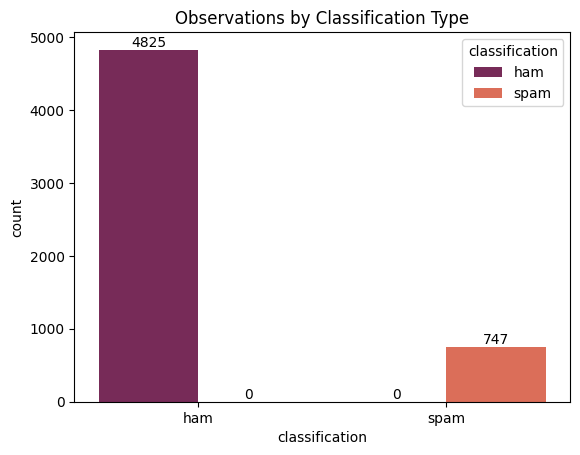

In [19]:
# Explore distribution of dataset

# count plot on single categorical variable
ax = sns.countplot(x = data['classification'], palette = 'rocket',hue = data['classification'])

#add data labels
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

In [20]:
# Dropping all duplicate texts based off of results of EDA
df_no_dup = data.drop_duplicates(subset=['text'], keep='first')

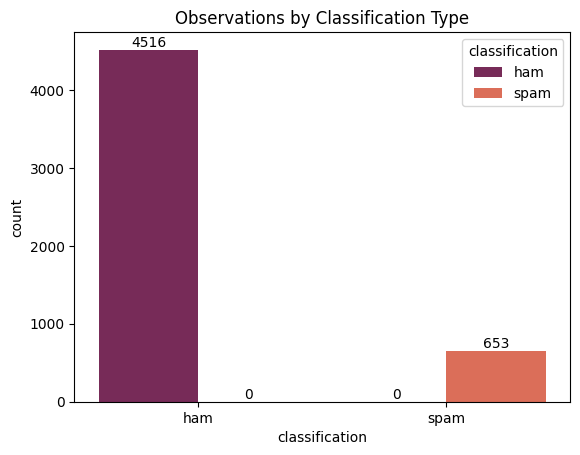

In [21]:
# Explore distribution of dataset

# count plot on single categorical variable
ax = sns.countplot(x = df_no_dup['classification'], palette = 'rocket',hue = df_no_dup['classification'])

#add data labels
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

In [22]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, Y_train, Y_test = train_test_split(df_no_dup['text'],
                                                    df_no_dup['target'],
                                                    test_size=0.3,
                                                    random_state=0)
print(X_train.shape,X_test.shape)

(3618,) (1551,)


In [23]:
def text_clean(text, method, rm_stop):
    text = re.sub(r"\n","",text)   #remove line breaks
    text = text.lower() #convert to lowercase
    #before running the following, remove hyperlinks, etc., as removing the digits can affect being able to find currency terms and hyperlinks
    text = re.sub(r"\d+","",text)   #remove numbers with one or more digits
    text = re.sub(r'[^\x00-\x7f]',r' ',text)   #remove non-ascii (everything without a code from x00 to x7f)
    text = re.sub(r'[^\w\s]','',text)   #remove punctuation (everything not a word or space)
    text = re.sub(r'https', '', text)   #remove hyperlinks

    #remove stop words
    if rm_stop == True:
        filtered_tokens = [word for word in word_tokenize(text) if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)

    #lemmatization: typically preferred over stemming
    if method == 'L':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) for word in word_tokenize(text)]
        return " ".join(lemm_tokens)

    #stemming
    if method == 'S':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) for word in word_tokenize(text)]
        return " ".join(stem_tokens)

    return text

In [24]:
#preprocessed data: Lemm + stopword removal
preprocessed_text_1 = [text_clean(text, 'L', True) for text in X_train]
#preprocessed_text_1[0:10]

#preprocessed data: Lemm + no stopword removal
preprocessed_text_2 = [text_clean(text, 'L', False) for text in X_train]
#preprocessed_text_2[0:10]

#preprocessed data: Stem + stopword removal
preprocessed_text_3 = [text_clean(text, 'S', True) for text in X_train]
#preprocessed_text_3[0:10]

#preprocessed data: Stem + no stopword removal
preprocessed_text_4 = [text_clean(text, 'S', False) for text in X_train]
#preprocessed_text_4[0:10]

In [25]:
def transform_model_data_w_count_vectorizer(preprocessed_text, Y_train,  X_test, Y_test, model_type):
    #vectorize dataset
    vectorizer = CountVectorizer()
    vectorized_data = vectorizer.fit_transform(preprocessed_text)

    #define model
    if model_type == 0:
        model = MultinomialNB(alpha=0.1)
    else:
        model = BernoulliNB(alpha=0.1)

    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(vectorizer.transform(X_test))
    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions, model

In [26]:
def transform_model_data_w_tfidf_vectorizer(preprocessed_text, Y_train,  X_test, Y_test, model_type):
    #vectorize dataset
    tfidf = TfidfVectorizer()
    vectorized_data = tfidf.fit_transform(preprocessed_text)

    #define model
    if model_type == 0:
        model = MultinomialNB(alpha=0.1)
    else:
        model = BernoulliNB(alpha=0.1)

    model.fit(vectorized_data, Y_train)

    #evaluate model
    predictions = model.predict(tfidf.transform(X_test))

    accuracy = accuracy_score( Y_test, predictions)
    balanced_accuracy = balanced_accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions)

    print("Accuracy:",round(100*accuracy,2),'%')
    print("Balanced accuracy:",round(100*balanced_accuracy,2),'%')
    print("Precision:", round(100*precision,2),'%')
    return predictions, model

In [27]:
#vectorize, model, and evaluate model using CountVectorizer and MultinomialNB
#note that x_test is not cleaned

#Lemm + stopword removal
print("Lemm + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test, 0)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test, 0)

#Stem + stopword removal
print("\nStem + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test, 0)

#Stem + no stopword removal
print("\nStem + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test, 0)

Lemm + stopword removal + CountVectorizer
Accuracy: 97.55 %
Balanced accuracy: 94.57 %
Precision: 90.55 %

Lemm + no stopword removal + CountVectorizer
Accuracy: 97.42 %
Balanced accuracy: 93.86 %
Precision: 90.86 %

Stem + stopword removal + CountVectorizer
Accuracy: 96.91 %
Balanced accuracy: 90.6 %
Precision: 93.22 %

Stem + no stopword removal + CountVectorizer
Accuracy: 97.29 %
Balanced accuracy: 91.88 %
Precision: 93.92 %


(array([0, 0, 0, ..., 0, 0, 0]), MultinomialNB(alpha=0.1))

In [28]:
#vectorize, model, and evaluate model using TfidfVectorizer and MultinomialNB
#note that x_test is not cleaned

#Lemm + stopword removal
print("Lemm + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test, 0)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test, 0)

#Stem + stopword removal
print("\nStem + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test, 0)

#Stem + no stopword removal
print("\nStem + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test, 0)

Lemm + stopword removal + TfidfVectorizer
Accuracy: 97.36 %
Balanced accuracy: 91.92 %
Precision: 94.44 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy: 97.61 %
Balanced accuracy: 92.07 %
Precision: 96.59 %

Stem + stopword removal + TfidfVectorizer
Accuracy: 96.07 %
Balanced accuracy: 85.46 %
Precision: 97.95 %

Stem + no stopword removal + TfidfVectorizer
Accuracy: 96.45 %
Balanced accuracy: 86.53 %
Precision: 99.32 %


(array([0, 0, 0, ..., 0, 0, 0]), MultinomialNB(alpha=0.1))

Accuracy: 96.45 %
Balanced accuracy: 86.53 %
Precision: 99.32 %


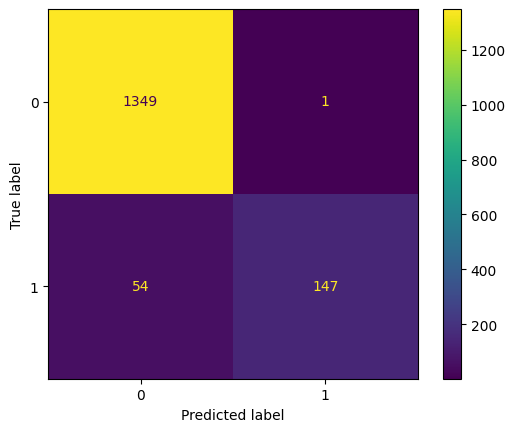

In [29]:
predictions, model = transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test, 0)
#compute the confusion matrix.
cm = confusion_matrix(Y_test, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [30]:
#vectorize, model, and evaluate model using CountVectorizer and BernoulliNB

#Lemm + stopword removal
print("Lemm + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test, 1)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test, 1)

#Stem + stopword removal
print("\nStem + stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test, 1)

#Stem + no stopword removal
print("\nStem + no stopword removal + CountVectorizer")
transform_model_data_w_count_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test, 1)

Lemm + stopword removal + CountVectorizer
Accuracy: 98.19 %
Balanced accuracy: 93.46 %
Precision: 98.87 %

Lemm + no stopword removal + CountVectorizer
Accuracy: 98.19 %
Balanced accuracy: 93.46 %
Precision: 98.87 %

Stem + stopword removal + CountVectorizer
Accuracy: 96.32 %
Balanced accuracy: 85.82 %
Precision: 100.0 %

Stem + no stopword removal + CountVectorizer
Accuracy: 97.55 %
Balanced accuracy: 90.55 %
Precision: 100.0 %


(array([0, 0, 0, ..., 0, 0, 0]), BernoulliNB(alpha=0.1))

In [31]:
#vectorize, model, and evaluate model using TfidfVectorizer and BernoulliNB

#Lemm + stopword removal
print("Lemm + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_1, Y_train,  X_test, Y_test, 1)

#Lemm + no stopword removal
print("\nLemm + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_2, Y_train,  X_test, Y_test, 1)

#Stem + stopword removal
print("\nStem + stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_3, Y_train,  X_test, Y_test, 1)

#Stem + no stopword removal
print("\nStem + no stopword removal + TfidfVectorizer")
transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test, 1)

Lemm + stopword removal + TfidfVectorizer
Accuracy: 98.19 %
Balanced accuracy: 93.46 %
Precision: 98.87 %

Lemm + no stopword removal + TfidfVectorizer
Accuracy: 98.19 %
Balanced accuracy: 93.46 %
Precision: 98.87 %

Stem + stopword removal + TfidfVectorizer
Accuracy: 96.32 %
Balanced accuracy: 85.82 %
Precision: 100.0 %

Stem + no stopword removal + TfidfVectorizer
Accuracy: 97.55 %
Balanced accuracy: 90.55 %
Precision: 100.0 %


(array([0, 0, 0, ..., 0, 0, 0]), BernoulliNB(alpha=0.1))

Accuracy: 97.55 %
Balanced accuracy: 90.55 %
Precision: 100.0 %


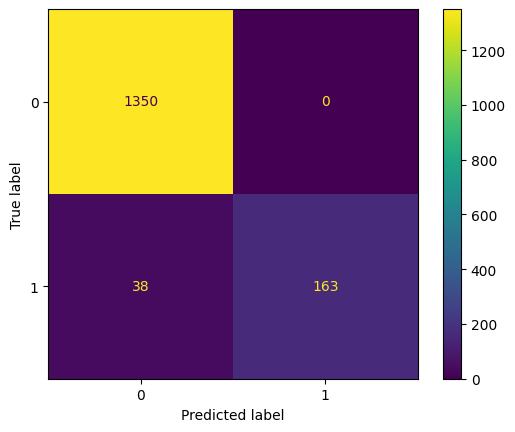

In [32]:
predictions, model = transform_model_data_w_tfidf_vectorizer(preprocessed_text_4, Y_train,  X_test, Y_test, 1)
#compute the confusion matrix.
cm = confusion_matrix(Y_test, predictions)

 #Plot the confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [33]:
#adapted from https://github.com/kk7nc/Text_Classification
#Rocchio Classifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', NearestCentroid()),
                     ])

In [34]:
text_clf.fit([text_clean(text, 'L', True) for text in X_train],Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', NearestCentroid())])

In [35]:
#note that X_test is not cleaned
predicted = text_clf.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1350
           1       0.79      0.85      0.82       201

    accuracy                           0.95      1551
   macro avg       0.88      0.91      0.90      1551
weighted avg       0.95      0.95      0.95      1551



In [36]:
#adapted from https://github.com/kk7nc/Text_Classification
#kNN Classifier - default of 5 neighbors
text_clf_2 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=5)),
                     ])

In [37]:
text_clf_2.fit([text_clean(text, 'L', True) for text in X_train],Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

In [38]:
#note that X_test is not cleaned
predicted = text_clf_2.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1350
           1       1.00      0.25      0.40       201

    accuracy                           0.90      1551
   macro avg       0.95      0.62      0.67      1551
weighted avg       0.91      0.90      0.88      1551



In [39]:
#adapted from https://github.com/kk7nc/Text_Classification
#Support Vector Machine
text_clf_3 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC(dual=False)),
                     ])

In [40]:
text_clf_3.fit([text_clean(text, 'L', True) for text in X_train],Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(dual=False))])

In [41]:
#note that X_test is not cleaned
predicted = text_clf_3.predict(X_test)
print(metrics.classification_report(Y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1350
           1       0.95      0.83      0.89       201

    accuracy                           0.97      1551
   macro avg       0.96      0.91      0.94      1551
weighted avg       0.97      0.97      0.97      1551



In [42]:
#adapted from https://www.kaggle.com/code/kshitij192/spam-email-classification-using-bert
#BERT (Bidirectional Encode Representations from Transformers) Classification
#BERT is pre-trained on Wikipedia and the Brown Corpus as unlabeled data
df_no_dup.groupby('classification').describe()

target                                    duplicates  \
                 count mean  std  min  25%  50%  75%  max      count   
classification                                                         
ham             4516.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     4516.0   
spam             653.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0      653.0   

                                                             
                    mean       std  min  25%  50%  75%  max  
classification                                               
ham             0.042958  0.202786  0.0  0.0  0.0  0.0  1.0  
spam            0.133231  0.340085  0.0  0.0  0.0  0.0  1.0

In [43]:
#balancing the data
df_spam = df_no_dup[df_no_dup['classification']=='spam']
print(df_spam.shape)
df_ham = df_no_dup[df_no_dup['classification']=='ham']
print(df_ham.shape)
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
print(df_ham_downsampled.shape)
df_balanced = pd.concat([df_ham_downsampled,df_spam])
print(df_balanced.shape)
df_balanced['classification'].value_counts()

(653, 4)
(4516, 4)
(653, 4)
(1306, 4)


ham     653
spam    653
Name: classification, dtype: int64

In [44]:
df_balanced.head()

,classification,text,target,duplicates
4429,ham,Aiyar dun disturb u liao... Thk u have lots 2 ...,0,0
1575,ham,My sis is catching e show in e afternoon so i'...,0,0
1232,ham,have got * few things to do. may be in * pub l...,0,0
2710,ham,Sorry de i went to shop.,0,0
4190,ham,"Well the general price is &lt;#&gt; /oz, let ...",0,0


In [45]:
df_balanced.tail()

,classification,text,target,duplicates
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,1,0
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1,0
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,1,0
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1,0
5567,spam,This is the 2nd time we have tried 2 contact u...,1,0


In [46]:
#the stratify parameter makes sure the proportions of 1's and 0's are preserved in the training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(df_balanced['text'],
                                                    df_balanced['target'],
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=df_balanced['target'])
print(X_train.shape,X_test.shape)
print(X_train.head(5))

(914,) (392,)
1915    New TEXTBUDDY Chat 2 horny guys in ur area 4 j...
4912    Love that holiday Monday feeling even if I hav...
2687    There r many model..sony ericson also der.. &l...
3631    Get the official ENGLAND poly ringtone or colo...
1361    Yo dude guess who just got arrested the other day
Name: text, dtype: object


In [47]:
#download the BERT pretrained model
#convert raw text to numeric input tensors input to the encoder
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#encoder stack of the transformer model to output the token representation of each input
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [49]:
#return the embedding of sentences
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [50]:
#After getting the embedding, can compare them using cosine similarity
c=get_sentence_embedding(['mango','banana','Narendra modi','data analytics','natural language processing'])
print(cosine_similarity([c[0]],[c[1]]))
print(cosine_similarity([c[0]],[c[4]]))

[[0.99540985]]
[[0.74711466]]


In [51]:
#build a functional model rather than a sequential neural network model so layers
#  do not need to be attached in sequential order
#part or all of the inputs are connected directly to the output layer
#such an architecture enables the neural netowrk to learn both deep patterns and simple rules

#BERT layers
#text is passed to bert_preprocess
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)

#Processed text passed to bert_encoder
outputs = bert_encoder(preprocessed_text)

# Neural network layers

#Dropout layers to prevent overfitting
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [52]:
#set up metrics of accuracy, precision, and recall
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [53]:
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
29/29 [==============================] - 22s 329ms/step - loss: 0.6855 - accuracy: 0.5460 - precision: 0.5427 - recall: 0.5842
Epoch 2/10
29/29 [==============================] - 9s 311ms/step - loss: 0.5528 - accuracy: 0.7779 - precision: 0.7953 - recall: 0.7484
Epoch 3/10
29/29 [==============================] - 10s 344ms/step - loss: 0.4848 - accuracy: 0.8239 - precision: 0.8083 - recall: 0.8490
Epoch 4/10
29/29 [==============================] - 9s 326ms/step - loss: 0.4277 - accuracy: 0.8621 - precision: 0.8371 - recall: 0.8993
Epoch 5/10
29/29 [==============================] - 9s 317ms/step - loss: 0.3920 - accuracy: 0.8731 - precision: 0.8589 - recall: 0.8928
Epoch 6/10
29/29 [==============================] - 10s 336ms/step - loss: 0.3655 - accuracy: 0.8775 - precision: 0.8662 - recall: 0.8928
Epoch 7/10
29/29 [==============================] - 10s 339ms/step - loss: 0.3394 - accuracy: 0.8906 - precision: 0.8742 - recall: 0.9125
Epoch 8/10
29/29 [===================

In [54]:
model.evaluate(X_test, Y_test)

13/13 [==============================] - 5s 338ms/step - loss: 0.2998 - accuracy: 0.9005 - precision: 0.9026 - recall: 0.8980


[0.2997719943523407,
 0.9005101919174194,
 0.9025641083717346,
 0.8979591727256775]

In [55]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

13/13 [==============================] - 5s 310ms/step


In [56]:
#If probablity greater than 0.5 than make it 1 otherwise 0.
#If y_predicted=1->spam
#else:Not spam
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,

In [57]:
cm = confusion_matrix(Y_test, y_predicted)
cm

array([[177,  19],
       [ 20, 176]])

Text(50.722222222222214, 0.5, 'Truth')

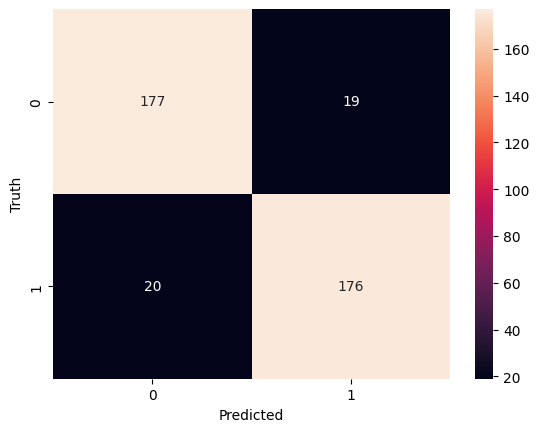

In [58]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [59]:
print(classification_report(Y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       196
           1       0.90      0.90      0.90       196

    accuracy                           0.90       392
   macro avg       0.90      0.90      0.90       392
weighted avg       0.90      0.90      0.90       392



In [ ]:
#Test the model on new input
#First 3 are spam and last 2 are not spam
reviews = [
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."]

model.predict(reviews)

In [60]:
model.save("bert_spam_classifier_v2")

In [61]:
del model

In [62]:
model = tf.keras.models.load_model("bert_spam_classifier_v2")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [63]:
#Test the model on new input
#First 3 are spam and last 2 are not spam
reviews = [
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."]

model.predict(reviews)

1/1 [==============================] - 1s 853ms/step


array([[0.7616968 ],
       [0.7629861 ],
       [0.71872747],
       [0.22558317],
       [0.12663795]], dtype=float32)